In [31]:
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def read_chunks(file, cols, chunk_size=500000):
    df = pd.read_json(
        f'/Users/ryounes/Documents/Feup/RecSNA_Project/yelp_academic_dataset_{file}.json', chunksize = chunk_size, lines=True)
    
    chunk_list = [chunk[cols] for chunk in df ]

    return pd.concat(chunk_list, ignore_index = True, join = 'outer', axis = 0)

In [4]:
business_json_path = '/Users/ryounes/Documents/Feup/RecSNA_Project/yelp_academic_dataset_business.json'
df_b = pd.read_json(business_json_path, lines=True)

In [25]:
df_u =  read_chunks('user', ['user_id','name','review_count', 'friends'])

In [6]:
df_r = read_chunks('review', ['review_id','user_id', 'business_id','stars'])

In [7]:
df_Franklin_b = df_b[df_b['city']== 'Franklin']

In [12]:
# Filter reviews for businesses in Franklin directly
business_ids_Franklin = df_Franklin_b['business_id'].unique()
df_r_Franklin = df_r[df_r['business_id'].isin(business_ids_Franklin)]

In [26]:
# Extract unique user IDs who left reviews for businesses in Franklin
Franklin_reviewed_user_ids = df_r_Franklin['user_id'].unique()

df_users_Franklin = df_u[df_u['user_id'].isin(Franklin_reviewed_user_ids)]

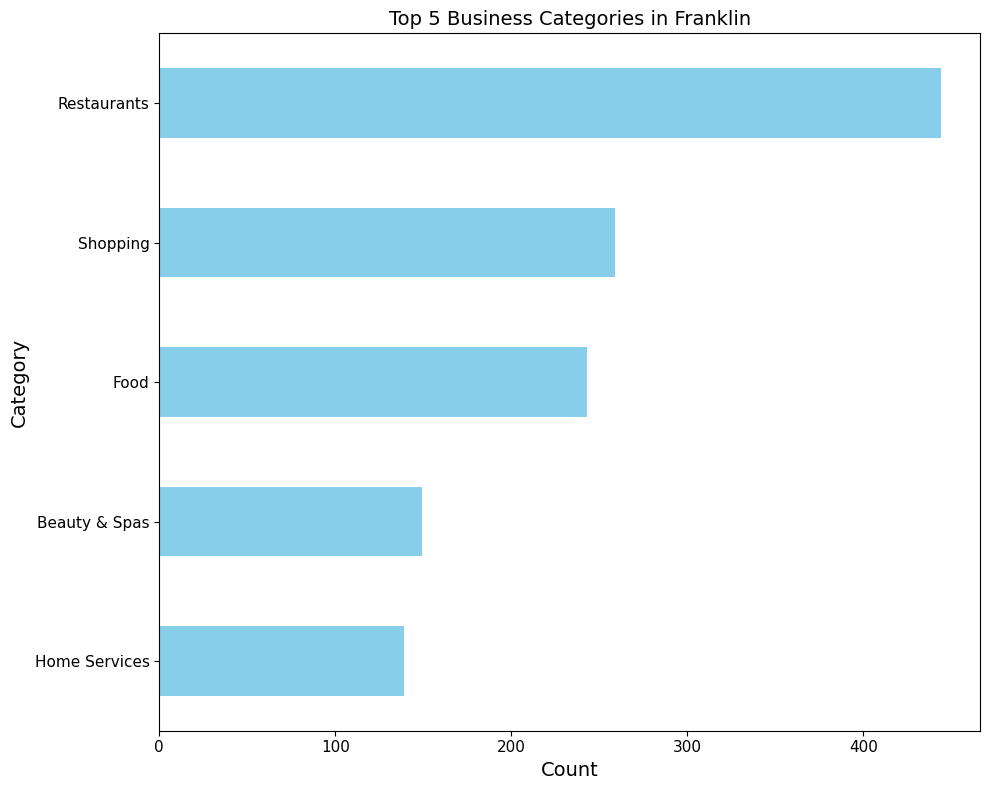

In [79]:


# Extract and flatten the categories column
categories_series = df_Franklin_b['categories']
# Split the categories and store them as a list of lists
category_lists = df_Franklin_b['categories'].str.split(',')

# Flatten the list of lists and strip whitespace from each category
all_categories = [category.strip() for sublist in category_lists.dropna() for category in sublist]
# Create a pandas Series to count the occurrences of each category
category_counts = pd.Series(all_categories).value_counts()

# Plot the top 5 categories
top_categories = category_counts.head(5)
plt.figure(figsize=(10, 8))
top_categories.plot( kind='barh',color='skyblue')
plt.title(f'Top 5 Business Categories in {"Franklin"}', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.gca().invert_yaxis()  # Invert the y-axis to display the most popular category at the top
plt.tight_layout()
# Invert the y-axis to display the most popular category at the top

plt.show()




In [14]:
df_r_Franklin

,review_id,user_id,business_id,stars
406,89SF8MFoiY4mIhOgzAMVhA,S8rqFLdHCFAeibs52a4QpQ,kKk_2OAnCRbxX5rLqQYBHg,5
425,HyD8P-CcFU3FR75T0dJAhA,YsaJXW7VWV2bhoN5tokKrg,HCqmx4ENAZ76SAjoalj-MQ,4
693,3B41BdxNIENFP1EsCCybnw,B0fzg0eUWplNBzfSJsCFDg,VUOD8yD1jwq_pqRP8EETBQ,3
802,h0N47vwJhQMBH9mscX9zhw,11jQWQYTJkzIE6o3s5ID4Q,hn3Rg2JrhQoDJBEhrpuwWg,1
804,cgppGTg8LpqZObn_k69w2Q,TSxzAqKzU2OvjWSLoSU8dA,skN2XhKXlcjf53uIwzAedw,5
...,...,...,...,...
6989373,Rjv4qf02STIbSUu5mq4W4w,U0kiORl1Gpc8K9jOWWgHzg,yi5VHfhTIPopCob2toQH8A,1
6989504,B50r7a0YV-WnBgf3bW-Dyw,H9AGj0t3ghPaHug0Ri3kOQ,y8AENR609baGvVe-d_F-dg,1
6989863,lbhfWHGz3C6dyLp_aiKadg,EUITvLX8HgKpJPs8ngXRPw,7rxLUgFNwAWd69Y4iZnUCA,5
6990131,sXMx4wAegK38PRbzyWe5Bg,4Ry0q14UDewv2LMa2wibCQ,IoRTm7IAJqBbHpiisUBnLg,4


In [45]:
# Create a Surprise Dataset from the merged DataFrame
reader = Reader(rating_scale=(1, 5))  # Define the rating scale
data = Dataset.load_from_df(df_r_Franklin[['user_id', 'business_id', 'stars']], reader)


In [46]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42 )

In [17]:
# Define evaluation function
def evaluate_algorithm(algo, trainset, testset):
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and return RMSE
    rmse = accuracy.rmse(predictions)
    return rmse

In [24]:
ubcf_algo = KNNBasic(sim_options={'user_based': True})
ubcf_rmse = evaluate_algorithm(ubcf_algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5499


In [25]:
ibcf_algo = KNNBasic(sim_options={'user_based': False})
ibcf_rmse = evaluate_algorithm(ibcf_algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5693


In [26]:
# Singular Value Decomposition (SVD)
svd_algo = SVD()
svd_rmse = evaluate_algorithm(svd_algo, trainset, testset)

RMSE: 1.3738


In [27]:
ubcf_algo = KNNBasic(sim_options={'user_based': True})
cross_validate(ubcf_algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5324  1.5489  1.5447  1.5593  1.5376  1.5446  0.0093  
MAE (testset)     1.2708  1.2898  1.2813  1.2944  1.2706  1.2814  0.0097  
Fit time          6.47    6.93    7.04    6.94    6.98    6.87    0.21    
Test time         0.90    0.68    0.68    0.77    0.69    0.74    0.09    


{'test_rmse': array([1.53243037, 1.54893376, 1.54466266, 1.55928158, 1.53764759]),
 'test_mae': array([1.27079061, 1.2897851 , 1.28128195, 1.29435797, 1.27059805]),
 'fit_time': (6.466526985168457,
  6.929379224777222,
  7.03980016708374,
  6.9407618045806885,
  6.975151300430298),
 'test_time': (0.9030938148498535,
  0.6826369762420654,
  0.6790499687194824,
  0.7651760578155518,
  0.6874241828918457)}

In [28]:
def recommend_top_n(algo, trainset, user_id, n=10):
    user_ratings = trainset.ur[user_id]
    items = [item_id for (item_id, _) in user_ratings]
    
    item_scores = {}
    for item_id in trainset.all_items():
        if item_id not in items:
            prediction = algo.predict(trainset.to_raw_uid(user_id), trainset.to_raw_iid(item_id), verbose=False)
            item_scores[item_id] = prediction.est
    
    top_items = sorted(item_scores, key=item_scores.get, reverse=True)[:n]

    #from raw_id to actual_id
    return [trainset.to_raw_iid(i) for i in top_items]

In [39]:
# Get recommendations for a specific user using the User-Based CF model
user_id = 6 # Change to the desired user ID
ibcf_top_items = recommend_top_n(svd_algo, trainset, user_id, n=5)
print("Top 5 Item-Based CF Recommendations for User", trainset.to_raw_uid(user_id), ":", ibcf_top_items)

Top 5 Item-Based CF Recommendations for User rS6Mrw7NyBQO_SK069n85A : ['gP_oWJykA2RocIs_GurKWQ', 'EkYh3uDgTxLbaLEpRtg3Ig', '9mE7Xp0hH6TMv3eaf2Ylxg', 'yktnwboMIQZkOvcZywktzA', 'QQHYGzspSIURR9Uw5jv5aA']


In [41]:
df_Franklin_b[df_Franklin_b['business_id']=='gP_oWJykA2RocIs_GurKWQ']

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
70650,gP_oWJykA2RocIs_GurKWQ,Yats,"2000 Mallory Ln, Ste 615",Franklin,TN,37067,35.948778,-86.818172,5.0,623,1,"{'ByAppointmentOnly': 'False', 'RestaurantsAtt...","Cajun/Creole, Restaurants, Caterers, Comfort F...","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
ubcf_algo = KNNBasic(sim_options={'user_based': True})
ubcf_algo.fit(trainset)
predictions = ubcf_algo.test(testset)

# Extract ground truth labels and predicted labels
actual_labels = [int(r[2]) for r in testset]  # Extracting actual ratings
predicted_labels = [int(pred.est) for pred in predictions]  # Extracting predicted ratings

# Calculate precision
precision = precision_score(actual_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(actual_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Precision: 0.46
Recall: 0.16
F1-Score: 0.15


In [20]:
ibcf_algo = KNNBasic(sim_options={'user_based': False})
ibcf_algo.fit(trainset)
predictions = ibcf_algo.test(testset)

# Extract ground truth labels and predicted labels
actual_labels = [int(r[2]) for r in testset]  # Extracting actual ratings
predicted_labels = [int(pred.est) for pred in predictions]  # Extracting predicted ratings

# Calculate precision
precision = precision_score(actual_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(actual_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Precision: 0.46
Recall: 0.20
F1-Score: 0.21


In [21]:

svd_algo = SVD()
svd_algo.fit(trainset)
predictions = svd_algo.test(testset)

# Extract ground truth labels and predicted labels
actual_labels = [int(r[2]) for r in testset]  # Extracting actual ratings
predicted_labels = [int(pred.est) for pred in predictions]  # Extracting predicted ratings

# Calculate precision
precision = precision_score(actual_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(actual_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.57
Recall: 0.16
F1-Score: 0.11


In [22]:
# Extract unique user IDs who left reviews for businesses in Franklin
Franklin_reviewed_user_ids = df_r_Franklin['user_id'].unique()

df_users_Franklin = df_u[df_u['user_id'].isin(Franklin_reviewed_user_ids)]

In [23]:
df_users_Franklin

,user_id,name,friends
26,kggqL33iZjeHmUn1Rtdjzg,Jay,"5-cF_paDOoXPtgaAeE_XyQ, bwPqqPZ0u5ak_Lr45V1-CQ..."
37,KYBEVBAP7QUlt1LjmatTJg,Matthew,"B7ecAeAIrXg7sgmabS38pg, tLrEDEs1Zu5NNmVuUivxvA..."
38,QJI9OSEn6ujRCtrX06vs1w,J,"RyPeT_ICAtX8ah9dhDpEFw, W8r4aKPZFT3GPIQQDbqB6Q..."
60,LwZJFLGxQwjjeOgpqTJnfw,Lucas,"RHsmgIvCfnFL7DPNptKY8A, mObXpXBnaOV_UhE0gWwvPQ..."
145,8zkkuk8KOoNojZhTx0j5KA,Melissa,"p-lbHRoUAPC0OWmOXtzNIA, 0EXuIg5v5rnQzGh8P8uRKw..."
...,...,...,...
1987345,_zAH1G-sp3uNb9CGbY6mmQ,Jim,None
1987384,J5s1-bXtrYfhfDjLkEvnYw,Karry,None
1987558,b-FmQDc3uNtg7-WhS4wElQ,Celia,None
1987578,WXIaXyUFuP8Ci2CtehtBFA,Dana,None


In [27]:
# Filter users with non-empty friends
sample = df_users_Franklin[df_users_Franklin['friends'] != None]

# Filter users with specified conditions
sub = sample[(sample['review_count'] >= 2) &
             (sample['friends'].apply(lambda x: len(x.split(','))) >= 2)]

# Create links (nodes and edges)
sample_friends = sub[['user_id', 'friends']]
sample_users = sample_friends['friends'].str.split(',')
sample_dat = pd.DataFrame({
    'user_id': sample_friends['user_id'].repeat(sample_users.apply(len)),
    'friends': [friend for friends in sample_users for friend in friends]
})

In [28]:
sample_dat

,user_id,friends
26,kggqL33iZjeHmUn1Rtdjzg,5-cF_paDOoXPtgaAeE_XyQ
26,kggqL33iZjeHmUn1Rtdjzg,bwPqqPZ0u5ak_Lr45V1-CQ
26,kggqL33iZjeHmUn1Rtdjzg,UXeP1KGEB2msMfWpbaHu9A
26,kggqL33iZjeHmUn1Rtdjzg,A0LUk4nKBzD_i05FLowzkA
26,kggqL33iZjeHmUn1Rtdjzg,cMUmjwG-Q9I27CwXg3f0DQ
...,...,...
1885462,cNuZIG8PkR6_SxrR54PFjQ,Ay7jZg-DbsdEByKOTASvBQ
1892081,PqLQJxQDLduMbusq8foEng,SHzsuBXFyhzkhEKep0qLtw
1892081,PqLQJxQDLduMbusq8foEng,dLGF-EZJN2O5BEGcC9rSAw
1892081,PqLQJxQDLduMbusq8foEng,S4-X-HqlbRFW3-ll1qd3ew


In [29]:
# Take a random sample of 20k nodes
samp_net = sample_dat.sample(20000)

In [32]:
# Create a network
network = nx.from_pandas_edgelist(samp_net, source='user_id', target='friends')
network_s = nx.Graph(network)  # Ensure it's undirected

In [34]:
#Get the largest connected component
largest_component = max(nx.connected_components(network_s), key=len)
largest_component_graph = network_s.subgraph(largest_component)

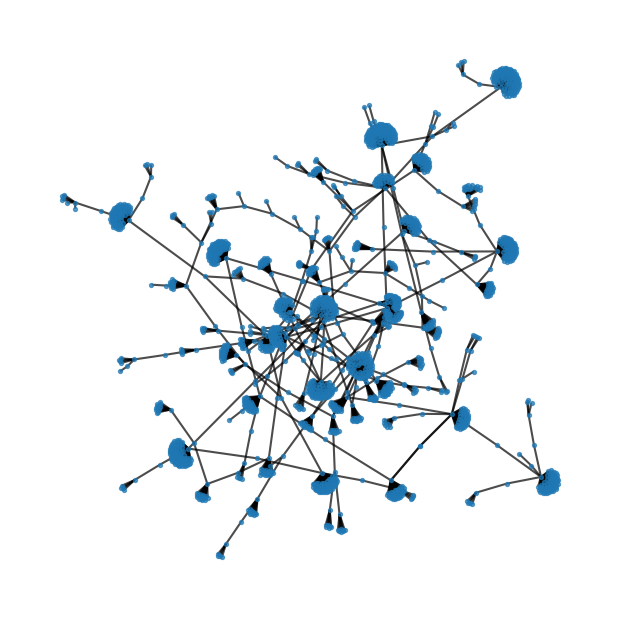

In [35]:
# Check if there are nodes in the largest connected component
if largest_component_graph.number_of_nodes() > 0:
    # Plot the largest connected component
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(largest_component_graph, seed=42)
    nx.draw(
        largest_component_graph,
        pos=pos,
        node_size=8,
        with_labels=False,
        edge_color='Black',
        width=1.5,
        alpha=0.7,
    )

    plt.axis('off')
    plt.savefig("largest_connected_component.png", dpi=300)
    plt.show()
else:
    print("The largest connected component has no nodes.")

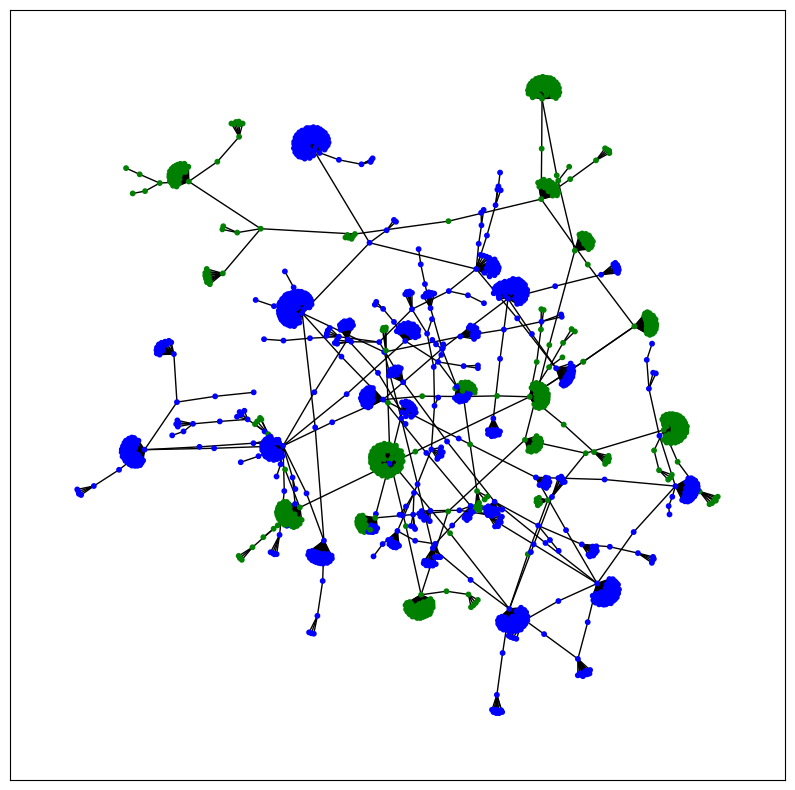

In [36]:
from networkx.algorithms import community
# Find communities
communities_generator = community.girvan_newman(largest_component_graph)
top_level_communities = next(communities_generator)
communities = sorted(map(sorted, top_level_communities))

# Create a color map for communities
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
color_map = {}

for i, community in enumerate(communities):
    for node in community:
        color_map[node] = colors[i % len(colors)]

# Draw the graph with different colors for each community
plt.figure(figsize=(10,10))
nx.draw_networkx(largest_component_graph, with_labels=False, node_size=10, node_color=[color_map[node] for node in largest_component_graph.nodes()])
plt.show()

In [37]:
len(communities)

2

In [38]:
#filter the reviews of the user in the community 
df_test = df_r[df_r['user_id'].isin(communities[0])]

In [39]:
df_test

,review_id,user_id,business_id,stars
197,IJCYT9dRjuBvY-BJufFnNg,hWDybu_KvYLSdEFzGrniTw,roc-xyyzN5b_nImb0NdRLQ,4
2841,f3v8aXk0sYlKixnUAyGjFQ,hL-p_AOo53wJyYrggzYMVg,GaLBEB3ZMr2GwOjFoIbkig,4
4200,mrrLGt64csq_miPGYWIRHw,hL-p_AOo53wJyYrggzYMVg,RTEdyP_6wGvXQugln1jxbg,4
4412,oCIs_NYaqI2ZV_Hw0MYTnw,SBjQX8BNQk4KtLVf8W14zQ,TwIouh_gbW9TCSK3PhuPrg,3
4523,wtmcUcibLjqk36XJQMoNRA,GRgDWg2tCNAANaIcFKS2bQ,oQ5CPRt0R3AzFvcjNOqB1w,5
...,...,...,...,...
6988055,9QXI4Pwxairf7GzVNfmpzw,kzRq4H_nSf4b3F_sdymWSw,ytynqOUb3hjKeJfRj5Tshw,5
6988867,Y-f8z1TC97moSA5hMvOj5Q,jc8xUrNwZRgXMSLr_qzAcA,aEZdzmzcpqgaaf7dYfieJg,5
6988933,ZHUej6nzle9Gl6oEQVqIVQ,6toEhpmJxknHFKBw5u3xWQ,VAeEXLbEcI9Emt9KGYq9aA,4
6989041,JqOG4y5g9GknWFzo-M6d5g,i_DR3vdE73nVm2GlMbGpGA,z7BDZS5DOW2WOFPcvZQISg,2


In [43]:
#apply the recommender systems to the users of the same community 
reader_ = Reader(rating_scale=(1, 5))  # Define the rating scale
data_ = Dataset.load_from_df(df_test[['user_id', 'business_id', 'stars']], reader_)

In [44]:
trainset_, testset_ = train_test_split(data_, test_size=0.2, random_state=42 )

In [47]:
ubcf_algo = KNNBasic(sim_options={'user_based': True})
ubcf_rmse = evaluate_algorithm(ubcf_algo, trainset_, testset_)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0832


In [48]:
# Item-Based Collaborative Filtering
ibcf_algo = KNNBasic(sim_options={'user_based': False})
ibcf_rmse = evaluate_algorithm(ibcf_algo, trainset_, testset_)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0472


In [49]:
# Singular Value Decomposition (SVD)
svd_algo = SVD()
svd_rmse = evaluate_algorithm(svd_algo, trainset_, testset_)

RMSE: 0.9823


In [50]:
ubcf_algo = KNNBasic(sim_options={'user_based': True})
ubcf_algo.fit(trainset_)
predictions = ubcf_algo.test(testset_)

# Extract ground truth labels and predicted labels
actual_labels = [int(r[2]) for r in testset_]  # Extracting actual ratings
predicted_labels = [int(pred.est) for pred in predictions]  # Extracting predicted ratings

# Calculate precision
precision = precision_score(actual_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(actual_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Precision: 0.44
Recall: 0.28
F1-Score: 0.25


In [51]:
ibcf_algo.fit(trainset_)
predictions = ibcf_algo.test(testset_)

# Extract ground truth labels and predicted labels
actual_labels = [int(r[2]) for r in testset_]  # Extracting actual ratings
predicted_labels = [int(pred.est) for pred in predictions]  # Extracting predicted ratings

# Calculate precision
precision = precision_score(actual_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(actual_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Precision: 0.42
Recall: 0.26
F1-Score: 0.21


In [52]:
svd_algo.fit(trainset_)
predictions = svd_algo.test(testset_)

# Extract ground truth labels and predicted labels
actual_labels = [int(r[2]) for r in testset_]  # Extracting actual ratings
predicted_labels = [int(pred.est) for pred in predictions]  # Extracting predicted ratings

# Calculate precision
precision = precision_score(actual_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(actual_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.51
Recall: 0.28
F1-Score: 0.21


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
